In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def get_data():
   dots_train = []
   for i in range(-50, 50):
      for j in range(-50, 50):
         if j >= -1 * i:
            dots_train.append([[i,j], 1])
         else:
            dots_train.append([[i,j], 0])

   dots_test = []

   for i in range(0, 100, 4):
      dots_test.append([[-55+i, 55], 1])
      dots_test.append([[55, -55+i], 1])

      dots_test.append([[-55+i, -55], 0])
      dots_test.append([[-55, -55+i], 0])

   np.random.shuffle(dots_train)
   np.random.shuffle(dots_test)

   dots_train_coords = []
   dots_train_answers = []
   dots_test_coords = []
   dots_test_answers = []
   for i in dots_train:
      dots_train_coords.append(i[0])
      dots_train_answers.append(i[1])
   for i in dots_test:
      dots_test_coords.append(i[0])
      dots_test_answers.append(i[1])

   return np.array(dots_train_coords), np.array(dots_train_answers),\
 np.array(dots_test_coords), np.array(dots_test_answers)

# Нейронная сеть состоит из двух нейронов входного слоя и одного нейрона выходного слоя
---
### Функция активации нейрона выходного слоя:
### Сигмоида: f(x) = ( 1 / (1 + e^(-x)))
### Производная сигмоиды: f'(x) = f(x)*(1 - f(x))
### Функция активации нейронов входного слоя: f(x) = x, её производная равна 1
---
# Алгоритм градиентного спуска (Back propagation):
---
1. Для выходного слоя: <br>
Локальный градиент σ2 = loss * f'(f_2_вых) <br>
Корректировка весов: w_2i = w_2i - h * σ2 * f_1_вых <br>
2. Для входного слоя: <br>
Локальный градиент: σ_1i = σ2 * w_2i * 1 <br>
Пояснение так как функция активации на входном слое f(x) = x, её производная равна f'(x) = 1 <br>
Корректировка весов: w_1i = w_1i - h * σ_1i * входное значение

In [4]:
class Model:
   def __init__(self):
      self.weights_input_layer = np.random.sample(2)
      self.weights_hidden_layer = np.random.sample(2)

   def Fit(self, x_train, y_train, epochs, batch_size, learning_rate):
      self.loss = 0
      self.history = {'loss' : [],
                      'accuracy' : [],
                      'epoch' : []}
      self.accuracy = 0
      data = np.column_stack([x_train, y_train])
      for i in range(epochs):
          rng = np.random.default_rng()
          batch = rng.choice(data, batch_size, replace = False)
          for j in range(batch_size):
            self.__train__(batch[:,0:2][j], batch[:,2][j], learning_rate)
          print(f'epoch: {i}, loss: {self.loss[0]:.3e}, accuracy: {self.accuracy / batch_size :.3f}')
          print(f'Веса входного слоя: {self.weights_input_layer}')
          print(f'Веса скрытого слоя: {self.weights_hidden_layer}')
          self.history['loss'].append(self.loss)
          self.history['accuracy'].append(self.accuracy / batch_size)
          self.history['epoch'].append(i)
          self.loss = 1
          self.accuracy = 0

   def Get_Summary(self):
      print(f'Начальные веса входного слоя: {self.weights_input_layer}')
      print(f'Начальные веса скрытого слоя: {self.weights_hidden_layer}')
      print(f'Всего связей: {len(self.weights_input_layer) + len(self.weights_hidden_layer)}')

   def __train__(self, dot, answer, learning_rate):
      activation_func_1 = lambda x : x
      activation_func_2 = lambda x : 1 / (1 + np.exp(-x))
      activation_func_2_diff = lambda x : activation_func_2(x) * (1 - activation_func_2(x))

      f_inp_1 = self.weights_input_layer * dot
      f_out_1 = np.array([activation_func_1(i) for i in f_inp_1])

      f_inp_2 = np.dot(self.weights_hidden_layer.reshape(1,2),f_out_1.reshape(2,1)).reshape(1)
      f_out_2 = activation_func_2(f_inp_2)

      loss_casual = f_out_2 - answer
      loss_MSLE = (np.log(1 + f_out_2) - np.log(1 + answer)) ** 2
      if abs(loss_casual) < 0.0001:
        self.accuracy += 1

      f_out_2_grads = loss_casual * activation_func_2_diff(f_inp_2)

      self.weights_hidden_layer -= learning_rate * f_out_2_grads * f_out_1

      f_out_1_grads = f_out_2_grads * self.weights_hidden_layer * 1

      self.weights_input_layer -= learning_rate * f_out_1_grads * dot

      self.loss = (self.loss + loss_MSLE) / 2
   def Evaluate(self, x_test, y_test):
      cnt = 0
      for i in range(len(x_test)):
        ans = abs(self.Predict(x_test[i]) - y_test[i]) < 0.0001
        cnt += ans
      print(f'Точность на тестовой выборке: {cnt.reshape(1)[0] / len(y_test)}')
   def Predict(self, x):
      activation_func_2 = lambda x : 1 / (1 + np.exp(-x))
      return activation_func_2(np.dot((x * self.weights_input_layer).reshape(1,2), self.weights_hidden_layer.reshape(2,1)))
   def History(self):
      return self.history

In [5]:
x_train, y_train, x_test, y_test = get_data()

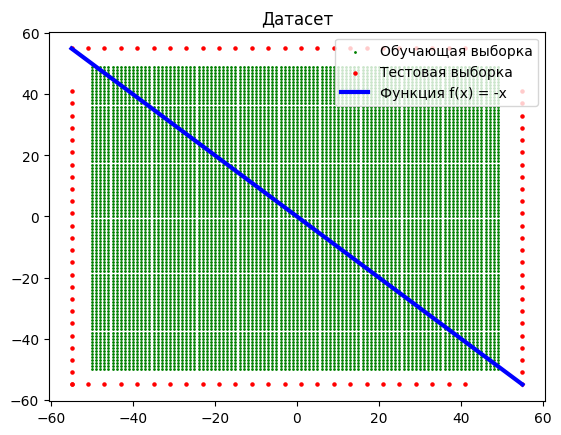

In [6]:
plt.title('Датасет')
plt.scatter(x_train[:, 0], x_train[:, 1], s = 1, color = 'green', label = 'Обучающая выборка')
plt.scatter(x_test[:, 0], x_test[:, 1], s = 5, color = 'red', label = 'Тестовая выборка')
plt.plot([-55, 55], [55, -55], color = 'blue', linewidth = 3, label = 'Функция f(x) = -x')
plt.legend()
plt.show()

Начальные веса входного слоя: [0.28462885 0.98131085]
Начальные веса скрытого слоя: [0.39021402 0.63091622]
Всего связей: 4
epoch: 0, loss: 1.210e-03, accuracy: 0.555
Веса входного слоя: [0.65545584 0.8897011 ]
Веса скрытого слоя: [0.6746956  0.41608806]
epoch: 1, loss: 2.214e-03, accuracy: 0.625
Веса входного слоя: [0.70571613 0.97609509]
Веса скрытого слоя: [0.68366916 0.51410919]
epoch: 2, loss: 8.089e-03, accuracy: 0.683
Веса входного слоя: [0.7777723  1.00810834]
Веса скрытого слоя: [0.73492359 0.53464886]
epoch: 3, loss: 3.553e-05, accuracy: 0.716
Веса входного слоя: [0.85135809 1.07396521]
Веса скрытого слоя: [0.7697247  0.58408153]
epoch: 4, loss: 2.269e-03, accuracy: 0.759
Веса входного слоя: [0.9076366  1.13064007]
Веса скрытого слоя: [0.79536181 0.62899247]
epoch: 5, loss: 7.269e-04, accuracy: 0.777
Веса входного слоя: [0.91572833 1.17813972]
Веса скрытого слоя: [0.78792729 0.68854258]
epoch: 6, loss: 2.726e-05, accuracy: 0.775
Веса входного слоя: [1.00962313 1.22951535]
Вес

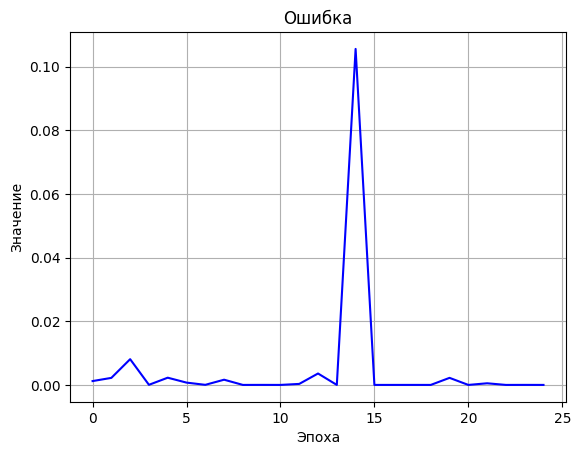

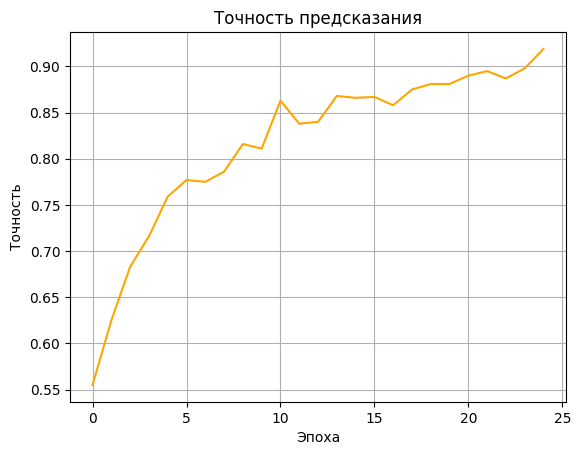

In [7]:
A = Model()
A.Get_Summary()
A.Fit(x_train, y_train, 25, 1000, 0.01)
A.Evaluate(x_test, y_test)
his = A.History()
plt.plot(his['epoch'], his['loss'], color = 'blue')
plt.grid()
plt.title('Ошибка')
plt.xlabel('Эпоха')
plt.ylabel('Значение')
plt.show()

plt.plot(his['epoch'], his['accuracy'], color = 'orange')
plt.grid()
plt.title('Точность предсказания')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.show()

# 2 Вариант

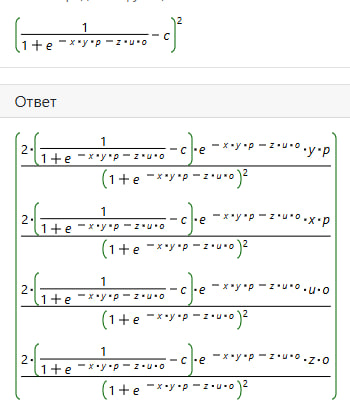

### x = w3
### y = w1
### z = w4
### u = w2

### f_out = 1 / (1 + e ^ (w3 * w1 * x + w4 * w2 * y))
---
## Идея:
### x_i = x_i - h * f'(x_i) - частная производная
### Это работает для например функции g(x) = (f(x) - ожидаемый результат), потому что чем дальше значение g(x), тем больше её производная (ex: у параболы больше угол наклона прямой)
### Таким образом если мы из каждого параметра x_i вычтем частную производную, умноженную на коэффициент, мы приблизим значение функции к ответу для данного случая.
### Проделав большое чмсло итераций в целом приблизим значения x_i к таким, чтобы значение функции было ближе к ответу

In [14]:
class Model_2(Model):
  def __train__(self, dot, answer, learning_rate):
      activation_func_1 = lambda x : x
      activation_func_2 = lambda x : 1 / (1 + np.exp(-x))

      f_inp_1 = self.weights_input_layer * dot
      f_out_1 = np.array([activation_func_1(i) for i in f_inp_1])

      f_inp_2 = np.dot(self.weights_hidden_layer.reshape(1,2),f_out_1.reshape(2,1)).reshape(1)
      f_out_2 = activation_func_2(f_inp_2)

      loss_optional = (f_out_2 - answer)
      loss_casual = (f_out_2 - answer)**2
      loss_MSLE = (np.log(1 + f_out_2) - np.log(1 + answer)) ** 2
      if abs(loss_casual) < 0.0001:
        self.accuracy += 1

      w1,w2 = self.weights_input_layer
      w3,w4 = self.weights_hidden_layer

      grads_2 = np.array([
          (2 * loss_optional * np.exp(f_inp_2) * w1 * dot[0]) / (1 + np.exp(f_inp_2)**2),
          (2 * loss_optional * np.exp(f_inp_2) * w2 * dot[1]) / (1 + np.exp(f_inp_2)**2)
      ]).reshape(2,)

      self.weights_hidden_layer -= learning_rate * grads_2

      grads_1 = np.array([
          (2 * loss_optional * np.exp(f_inp_2) * w3 * dot[0]) / (1 + np.exp(f_inp_2)**2),
          (2 * loss_optional * np.exp(f_inp_2) * w4 * dot[1]) / (1 + np.exp(f_inp_2)**2)
      ]).reshape(2,)

      self.weights_input_layer -= learning_rate * grads_1

      self.loss = (self.loss + loss_MSLE) / 2

Начальные веса входного слоя: [0.51948116 0.26350959]
Начальные веса скрытого слоя: [0.67426321 0.3410622 ]
Всего связей: 4
epoch: 0, loss: 1.994e-03, accuracy: 0.678
Веса входного слоя: [0.44401642 0.5154741 ]
Веса скрытого слоя: [0.60209868 0.55421609]
epoch: 1, loss: 1.514e-03, accuracy: 0.723
Веса входного слоя: [0.54062329 0.5449166 ]
Веса скрытого слоя: [0.66745125 0.57897695]
epoch: 2, loss: 1.699e-03, accuracy: 0.765
Веса входного слоя: [0.54588022 0.61436073]
Веса скрытого слоя: [0.66388195 0.64274884]
epoch: 3, loss: 2.542e-02, accuracy: 0.759
Веса входного слоя: [0.59814764 0.66407054]
Веса скрытого слоя: [0.69671934 0.68764537]
epoch: 4, loss: 4.051e-05, accuracy: 0.804
Веса входного слоя: [0.65681775 0.67426164]
Веса скрытого слоя: [0.74150867 0.69586845]
epoch: 5, loss: 7.775e-05, accuracy: 0.832
Веса входного слоя: [0.6467223  0.74856471]
Веса скрытого слоя: [0.7264568  0.76664623]
epoch: 6, loss: 2.831e-02, accuracy: 0.809
Веса входного слоя: [0.7317992 0.7245946]
Веса 

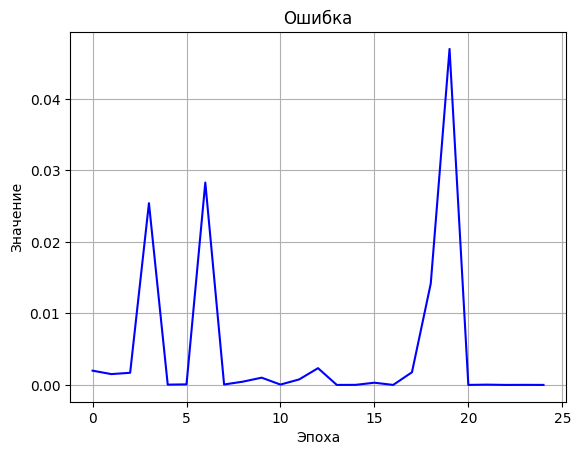

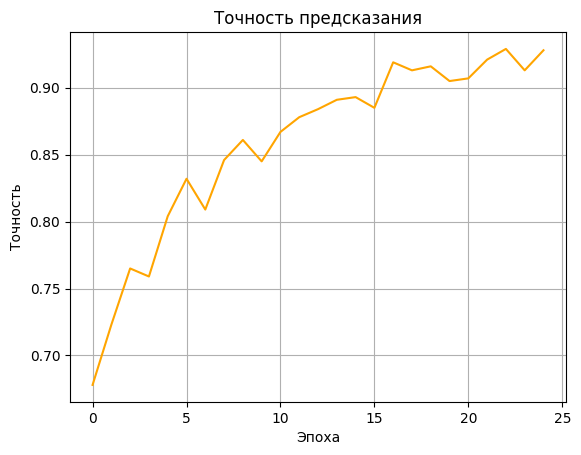

In [17]:
A = Model_2()
A.Get_Summary()
A.Fit(x_train, y_train, 25, 1000, 0.003)
A.Evaluate(x_test, y_test)
his = A.History()
plt.plot(his['epoch'], his['loss'], color = 'blue')
plt.grid()
plt.title('Ошибка')
plt.xlabel('Эпоха')
plt.ylabel('Значение')
plt.show()

plt.plot(his['epoch'], his['accuracy'], color = 'orange')
plt.grid()
plt.title('Точность предсказания')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.show()